In [ ]:
!pip install swig
!pip install gymnasium[box2d]
!pip install IPython


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 34.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373077 sha256=cfd6e4a6d3a4a28aede388d62c19c2da9aba412e04da947d928ba74cb2d4a1f1
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.4 MB/s eta 0:00:00


In [ ]:

import gym
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation
import numpy as np

Steps to try - Discretized Q-learning while discretizing the continuous observation space


1.   Define the states in the continuous space, based on intervals


*   So of the 8 dimensions, for example you can have [10 x 10 x 5 x 5 x 5 x 5 x 2 x 2] different states   


2.   Use Q-learning, build a value function based on rewards and states

3.   Train on a number of episodes and see how how much learning is done, ideally want to see quite a few successful landings.



In [ ]:
def categorize_number(num, range_dict):
    for (start, end), discrete in range_dict.items():
        if start-.01 <= num <= end+.01:
            return discrete
    return "Error"

def map_cont_to_discrete(observation, list_num_state):
    x_coord, y_coord, x_vel, y_vel, angle, ang_vel, left_leg, right_leg = observation
    env = gym.make('LunarLander-v2')
    env.reset(seed=42)
    #print(env.observation_space)
    low_values = np.array([-0.3, 0, -0.25, -0.5, -1, -1, 0, 0])
    high_values = np.array([0.3, 1.0, 0.25, 0.0, 1, 1, 0, 0])
    obs_range = high_values - low_values

    dicts_list = []
    for i, num_state in enumerate(list_num_state):
      out_dict = {}
      prev_low = low_values[i]
      out_dict[(-1e4, prev_low)] = 0

      for j in range(num_state):
        high_bound = prev_low + obs_range[i]/num_state
        out_dict[(prev_low, high_bound)] = j
        prev_low = high_bound
      out_dict[(prev_low, 10000)] = j
      dicts_list.append(out_dict)
    state = []
    for i in range(6):
      state.append(categorize_number(observation[i], dicts_list[i]))
    #print(dicts_list)
    return tuple(state+ [int(observation[-2])]+[int(observation[-1])])

env = gym.make('LunarLander-v2')
env.reset(seed=42)
action = env.action_space.sample()
list_num_state = [5,4,4,4,4,4,2,2]
for n_steps in range(10):
    observation, reward, done, info = env.step(action)
    map_cont_to_discrete(observation, list_num_state)
    print(map_cont_to_discrete(observation, list_num_state))
    print(observation)

(2, 3, 3, 3, 1, 1, 0, 0)
[ 0.00459394  1.424763    0.23233262  0.2947628  -0.00525882 -0.05208295
  0.          0.        ]
(2, 3, 3, 3, 1, 1, 0, 0)
[ 0.00689106  1.4307963   0.2323407   0.26813322 -0.00786133 -0.05205489
  0.          0.        ]
(2, 3, 3, 3, 1, 1, 0, 0)
[ 0.00918827  1.4362297   0.23234835  0.24146177 -0.01046348 -0.05204814
  0.          0.        ]
(2, 3, 3, 3, 1, 1, 0, 0)
[ 0.01148539  1.4410629   0.23235607  0.21479255 -0.01306525 -0.05204
  0.          0.        ]
(2, 3, 3, 3, 1, 1, 0, 0)
[ 0.01378269  1.4452963   0.23236378  0.18812372 -0.01566659 -0.05203186
  0.          0.        ]
(2, 3, 3, 3, 1, 1, 0, 0)
[ 0.01608009  1.4489295   0.23237145  0.16145499 -0.01826754 -0.05202375
  0.          0.        ]
(2, 3, 3, 3, 1, 1, 0, 0)
[ 0.01837749  1.4519632   0.23237911  0.13478617 -0.02086806 -0.05201556
  0.          0.        ]
(2, 3, 3, 3, 1, 1, 0, 0)
[ 0.02067509  1.4543966   0.23238671  0.10811727 -0.02346819 -0.05200743
  0.          0.        ]
(2, 3, 3, 3

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
class QLearningAgent(object):
    def __init__(self, alpha, list_num_state, epsilon, epsilon_decay):
        self.Q = None
        self.alpha = alpha
        self.gamma = 0.98
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.env = gym.make('LunarLander-v2')
        self.env.seed(42)
        self.tot_rewards = []
        self.max_iter = 10000
        self.list_num_state = list_num_state

    def solve(self):

        iters = 0
        converged = False
        x_coord, y_coord, x_vel, y_vel, angle, ang_vel, left_leg, right_leg = self.list_num_state

        n_actions = self.env.action_space.n

        if not isinstance(self.Q, np.ndarray):
            self.Q = np.zeros([x_coord, y_coord, x_vel, y_vel, angle, ang_vel, left_leg, right_leg, n_actions])

        tot_rewards = []
        while iters < self.max_iter:
            state = self.env.reset()

            state = map_cont_to_discrete(state, self.list_num_state)
            #print(state)
            done = False

            cur_rewards = 0
            while not done:
                # set the action based on epsilon greedy
                # since we set epsilon to 1 we just run random
                # try to fill up the Q table
                if np.random.random() < self.epsilon:
                    action = self.env.action_space.sample()
                else:
                    action = np.argmax(self.Q[state])

                observation, reward, done, _ = self.env.step(action)
                cur_rewards += reward # track how well our training has been doing
                new_state = map_cont_to_discrete(observation, self.list_num_state)
                max_value = np.max(self.Q[new_state])
                if done:
                  max_value = 0

                self.Q[state + (action,)] = self.Q[state + (action,)] + self.alpha * (reward + self.gamma * max_value - self.Q[state + (action,)])
                state = new_state

            # decay epsilon
            if self.epsilon_decay == 1:
                if iters > self.max_iter*0.1:
                  self.epsilon = 0.3
                if iters > self.max_iter*0.2:
                  self.epsilon = 0.2
                if iters > self.max_iter*0.3:
                  self.epsilon = 0.1
                if iters > self.max_iter*0.4:
                  self.epsilon = 0.05
                if iters > self.max_iter*0.5:
                  self.epsilon = 0.01
                if iters > self.max_iter*0.6:
                  self.epsilon = 0.01
            else:
                self.epsilon *= self.epsilon_decay

            iters += 1

            # update on training
            self.tot_rewards.append(round(cur_rewards,3))
            if iters % 100 == 0:
              print('finished ', iters ,' iterations')
              print('epsilon:', self.epsilon)
              print('avg_rewards', np.mean(self.tot_rewards[-100:]))



    def Q_table(self, state, action):
        """return the optimal value for State-Action pair in the Q Table"""
        return self.Q[state][action]

    def optimal_move(self, state):
        return np.argmax(self.Q[state])

    def return_actions_Q(self, state):
        """return the Q values of possible actions given a state"""
        return self.Q[state]

    def return_full_Q_table(self):
        """returns the full Q table"""
        return self.Q

In [38]:
## Experiments
## We will vary 3 hyperparameters, the discretizer, starting epsilon, and alpha
disc_settings = [[6,5,3,3,2,2,2,2], [6,5,4,4,4,4,2,2], [5,4,3,3,2,2,2,2], [5,4,4,4,4,4,2,2], [4,3,3,3,2,2,2,2], [4,3,4,4,4,4,2,2]]

# test discretizer settings, assuming constant alpha and constant epsilon
disc_averages = []
disc_rewards_list = []
for disc_setting in disc_settings:
    a = QLearningAgent(alpha=0.2, list_num_state=disc_setting, epsilon=0.99, epsilon_decay=1)
    a.max_iter = 1000
    a.solve()
    print(disc_setting, " ", np.mean(a.tot_rewards[-100:]))
    disc_averages.append(np.mean(a.tot_rewards[-100:]))
    disc_rewards_list.append(a.tot_rewards)
print(disc_averages)


finished  100  iterations
epsilon: 0.99
avg_rewards -188.47857000000005
finished  200  iterations
epsilon: 0.3
avg_rewards -123.044
finished  300  iterations
epsilon: 0.2
avg_rewards -135.21743
finished  400  iterations
epsilon: 0.1
avg_rewards -116.74897000000001
finished  500  iterations
epsilon: 0.05
avg_rewards -108.71882000000001
finished  600  iterations
epsilon: 0.01
avg_rewards -127.52302000000002
finished  700  iterations
epsilon: 0.01
avg_rewards -77.52513
finished  800  iterations
epsilon: 0.01
avg_rewards -55.70538
finished  900  iterations
epsilon: 0.01
avg_rewards -69.06851
finished  1000  iterations
epsilon: 0.01
avg_rewards -78.99571000000002
[6, 5, 3, 3, 2, 2, 2, 2]   -78.99571000000002
finished  100  iterations
epsilon: 0.99
avg_rewards -188.97213000000002
finished  200  iterations
epsilon: 0.3
avg_rewards -147.30128
finished  300  iterations
epsilon: 0.2
avg_rewards -111.32425
finished  400  iterations
epsilon: 0.1
avg_rewards -120.62107999999998
finished  500  itera

In [ ]:
# we will test different starting epsilon values, assuming the standard decay
# we will also test if we do a 0.99 decay rather than using the stepwise decay
epsilon_list = [(0.99, 1), (0.8, 1), (0.6, 1), (0.99, 0.99), (0.8, 0.99), (0.6, 0.99)]

# test epsilon settings, assuming others constant
epsilon_averages = []
epsilon_rewards_list = []
disc_setting = [6,5,3,3,2,2,2,2]
for epsilon, epsilon_decay in epsilon_list:
    a = QLearningAgent(alpha=0.2, list_num_state=disc_setting, epsilon=epsilon, epsilon_decay=epsilon_decay)
    a.max_iter = 1000
    a.solve()
    print(epsilon, " ", np.mean(a.tot_rewards[-100:]))
    epsilon_averages.append(np.mean(a.tot_rewards[-100:]))
    epsilon_rewards_list.append(a.tot_rewards)
print(epsilon_averages)


finished  100  iterations
epsilon: 0.99
avg_rewards -172.17864
finished  200  iterations
epsilon: 0.3
avg_rewards -149.23829
finished  300  iterations
epsilon: 0.2
avg_rewards -109.91855
finished  400  iterations
epsilon: 0.1
avg_rewards -110.85703
finished  500  iterations
epsilon: 0.05
avg_rewards -112.57700999999999
finished  600  iterations
epsilon: 0.01
avg_rewards -125.53641000000002
finished  700  iterations
epsilon: 0
avg_rewards -97.86353
finished  800  iterations
epsilon: 0
avg_rewards -70.28012
finished  900  iterations
epsilon: 0
avg_rewards -31.537219999999998
finished  1000  iterations
epsilon: 0
avg_rewards -36.294480000000014
0.99   -36.294480000000014
finished  100  iterations
epsilon: 0.8
avg_rewards -147.83133999999998
finished  200  iterations
epsilon: 0.3
avg_rewards -110.26131
finished  300  iterations
epsilon: 0.2
avg_rewards -111.73378999999997
finished  400  iterations
epsilon: 0.1
avg_rewards -131.67144
finished  500  iterations
epsilon: 0.05
avg_rewards -137.

In [ ]:
# lastly we will test different alpha
# we will also test if we do a 0.99 decay rather than using the stepwise decay
alphas = [0.05, 0.1, 0.2, 0.3, 0.4]

# test alpha settings, assuming others constant
alpha_averages = []
alpha_rewards_list = []
disc_setting = [6,5,3,3,2,2,2,2]
epsilon = 0.99

for alpha in alphas:
    a = QLearningAgent(alpha=alpha, list_num_state=disc_setting, epsilon=epsilon, epsilon_decay=1)
    a.max_iter = 1000
    a.solve()
    print(alpha, " ", np.mean(a.tot_rewards[-100:]))
    alpha_averages.append(np.mean(a.tot_rewards[-100:]))
    alpha_rewards_list.append(a.tot_rewards)
print(alpha_averages)

finished  100  iterations
epsilon: 0.99
avg_rewards -180.84068000000002
finished  200  iterations
epsilon: 0.3
avg_rewards -157.13199
finished  300  iterations
epsilon: 0.2
avg_rewards -171.03934
finished  400  iterations
epsilon: 0.1
avg_rewards -167.35234999999997
finished  500  iterations
epsilon: 0.05
avg_rewards -156.89939999999999
finished  600  iterations
epsilon: 0.01
avg_rewards -136.9531
finished  700  iterations
epsilon: 0
avg_rewards -129.24743999999998
finished  800  iterations
epsilon: 0
avg_rewards -102.61193999999999
finished  900  iterations
epsilon: 0
avg_rewards -111.48810999999998
finished  1000  iterations
epsilon: 0
avg_rewards -70.08597
0.05   -70.08597
finished  100  iterations
epsilon: 0.99
avg_rewards -198.64014999999995
finished  200  iterations
epsilon: 0.3
avg_rewards -132.64674999999997
finished  300  iterations
epsilon: 0.2
avg_rewards -118.67147000000001
finished  400  iterations
epsilon: 0.1
avg_rewards -115.89344999999999
finished  500  iterations
epsi

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


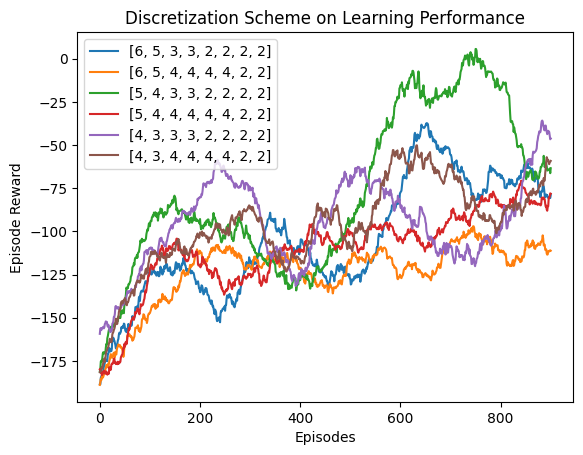

NameError: ignored

In [40]:
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/Colab_Images'
# Make the three plots for each variable that we tested
for n, disc_rewards in enumerate(disc_rewards_list):
    ma100_array = np.convolve(disc_rewards, np.ones(100)/100, mode='valid')
    plt.plot(ma100_array, label=str(disc_settings[n]))
plt.title('Discretization Scheme on Learning Performance')
plt.ylabel('Episode Reward')
plt.xlabel('Episodes')
plt.legend()
plt.savefig(f"{images_dir}/discretizing.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

for n, epsilon_rewards in enumerate(epsilon_rewards_list):
    ma100_array = np.convolve(epsilon_rewards, np.ones(100)/100, mode='valid')
    plt.plot(ma100_array, label=str(epsilon_list[n]))
plt.title('Epsilon on Learning Performance')
plt.ylabel('Episode Reward')
plt.xlabel('Episodes')
plt.legend()
plt.savefig(f"{images_dir}/epsilon.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

for n, alpha_rewards in enumerate(alpha_rewards_list):
    ma100_array = np.convolve(alpha_rewards, np.ones(100)/100, mode='valid')
    plt.plot(ma100_array, label=str(alphas[n]))
plt.title('Alpha on Learning Performance')
plt.ylabel('Episode Reward')
plt.xlabel('Episodes')
plt.legend()
plt.savefig(f"{images_dir}/alpha.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

In [41]:
disc_setting = [5,4,3,3,2,2,2,2]

a = QLearningAgent(alpha=0.1, list_num_state=disc_setting, epsilon=0.8, epsilon_decay=0.999)
a.max_iter=15000
a.solve()



finished  100  iterations
epsilon: 0.7238337176909673
avg_rewards -142.61246
finished  200  iterations
epsilon: 0.6549190635829087
avg_rewards -143.57511
finished  300  iterations
epsilon: 0.5925656257248799
avg_rewards -124.34192999999999
finished  400  iterations
epsilon: 0.5361487248053926
avg_rewards -96.89008000000001
finished  500  iterations
epsilon: 0.4851031558889486
avg_rewards -109.59327999999998
finished  600  iterations
epsilon: 0.4389175259883982
avg_rewards -94.40495999999999
finished  700  iterations
epsilon: 0.39712913074487977
avg_rewards -80.93905
finished  800  iterations
epsilon: 0.35931931888806046
avg_rewards -85.12716999999999
finished  900  iterations
epsilon: 0.3251092980361637
avg_rewards -68.24019
finished  1000  iterations
epsilon: 0.29415633981677136
avg_rewards -74.47237
finished  1100  iterations
epsilon: 0.26615034628992656
avg_rewards -84.60529999999999
finished  1200  iterations
epsilon: 0.24081074327471996
avg_rewards -99.30962
finished  1300  iterat

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


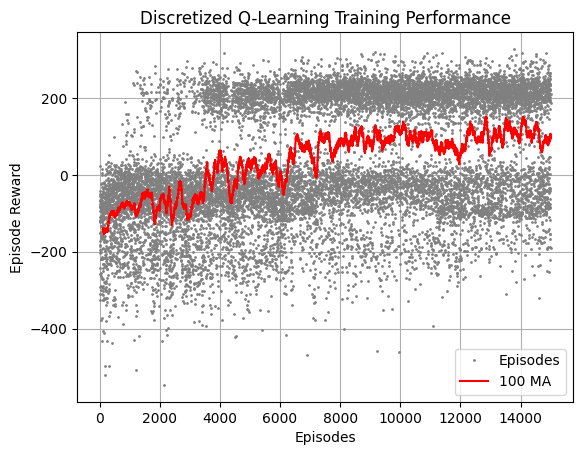

In [46]:
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/Colab_Images'

results_array = np.array(a.tot_rewards)
ma100_array = np.convolve(results_array, np.ones(100)/100, mode='valid')
with open('VQL_results.txt', 'w') as writefile:
    writefile.write(str(a.tot_rewards))
plt.plot(results_array, linestyle='', marker='o', markersize=1, label='Episodes', color='grey')
plt.plot(range(100,15001), ma100_array, color='red', label='100 MA')
plt.title('Discretized Q-Learning Training Performance')
plt.ylabel('Episode Reward')
plt.xlabel('Episodes')
plt.savefig(f"{images_dir}/discQL_plot.png", dpi=300, format='png', bbox_inches='tight')
plt.legend()
plt.grid(True)
plt.show()
#

In [45]:
## testing of final model

a.epsilon = 0
test_rewards = []
test_env = gym.make('LunarLander-v2')

for i in range(1000):
    state = test_env.reset()
    state = map_cont_to_discrete(state, [5,4,3,3,2,2,2,2])
    done = False

    cur_rewards = 0
    while not done:
        action = np.argmax(a.Q[state])
        observation, reward, done, _ = test_env.step(action)
        cur_rewards += reward # track how well our training has been doing
        new_state = map_cont_to_discrete(observation, [5,4,3,3,2,2,2,2])
        max_value = np.max(a.Q[new_state])
        if done:
            max_value = 0
        state = new_state
    test_rewards.append(round(cur_rewards,3))


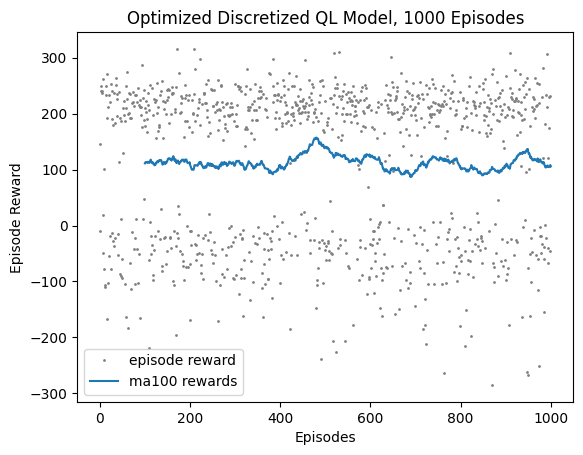

mean 111.381861
std 140.1013462955502
best stretch 157.30457999999996


In [48]:

test_rewards = np.array(test_rewards)
ma100_array = np.convolve(test_rewards, np.ones(100)/100, mode='valid')
plt.plot(test_rewards, linestyle='', marker='o', markersize=1, label='episode reward', color='grey')
plt.plot(range(100,1001), ma100_array, label='ma100 rewards')
plt.title('Optimized Discretized QL Model, 1000 Episodes')
plt.ylabel('Episode Reward')
plt.xlabel('Episodes')
plt.legend()
plt.savefig(f"{images_dir}/final_disc.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

print('mean', np.mean(test_rewards))
print('std', np.std(test_rewards))
print('best stretch', max(ma100_array))


Hyperparameters:
1. The discretizing dictionary - changes how many states there are
  - It will take many iterations to learn if there are many possible states that we can be in, so we will try to limit the discretization to a max of 2000 states.
  - We define the discretization with a list in which each parameter is represented with an integer number of separations.
  - We also define a "concentration" area of the observation space, where the discrete grid cuts will be made.
2. Epsilon and decay - changes how fast you will explore/exploit
3. Alpha
4. Gamma
5. Number of iterations



In [ ]:
# ## Animation code and visualization
# # Number of episodes
# num_episodes = 5
# disc = [6, 5, 3, 3, 2, 2, 2, 2]
# def display_frames_as_gif(frames):
#     plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
#     patch = plt.imshow(frames[0])
#     plt.axis('off')
#     def animate(i):
#         patch.set_data(frames[i])
#     ani = FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
#     display(HTML(ani.to_jshtml()))

# for _ in range(num_episodes):
#     observation = env.reset()
#     frames = []
#     done = False
#     episode_reward = 0
#     while not done:
#         frames.append(env.render(mode='rgb_array'))
#         state = map_cont_to_discrete(observation, disc)
#         action = a.optimal_move(state)
#         observation, reward, done, info = env.step(action)
#         episode_reward += reward
#     print(episode_reward, reward)
#     display_frames_as_gif(frames)

# env.close()